# Classification Model of Purchase Intentions
### DSCI100 Project Proposal Group 13

## Introduction
With e-commerce becoming more and more prevalent in today’s environment, businesses within this sector need to understand what factors influence a visitor to transform into a purchaser. Hence, a lot of current research is focused on real-time revenue predictors for these businesses.

##### In this project, we aim to build a classification model to predict the purchase intentions of prospective buyers, and determine whether they will make a purchase or not using the available website usage data. We would be using ProductRelated_Duration, PageValues and Administrative_Duration as our predictor variables for the classification. We have explained our choice of predictors and its reasoning in the analysis below.

This project uses a dataset from the UCI Machine Learning Repository called the Online Shoppers Purchasing Intention Dataset, which contains information about different users, such as the time spent in each web page and if that lead to a purchase or not.

The dataset consists of 12,330 rows of observations associated with 10 numerical and 8 categorical attributes. The dataset was formed so that each observation (session) would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period.

The attributes in the dataset can be split into three categories: data related to the page that the user lands on, Google Analytics metrics, and user visit data. The 'Revenue' attribute determines whether a session ended in a purchase or not, and would be used as the class label for our project.

## Methods & Results:

### Importing libraries and reading data

In [1]:
# load packages
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

# set seed
set.seed(3456)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Reading the data

In [2]:
# loading data from the original source on the web
shoppers_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv") %>%
            mutate(Revenue = as_factor(Revenue))
glimpse(shoppers_raw)

Parsed with column specification:
cols(
  Administrative = col_double(),
  Administrative_Duration = col_double(),
  Informational = col_double(),
  Informational_Duration = col_double(),
  ProductRelated = col_double(),
  ProductRelated_Duration = col_double(),
  BounceRates = col_double(),
  ExitRates = col_double(),
  PageValues = col_double(),
  SpecialDay = col_double(),
  Month = col_character(),
  OperatingSystems = col_double(),
  Browser = col_double(),
  Region = col_double(),
  TrafficType = col_double(),
  VisitorType = col_character(),
  Weekend = col_logical(),
  Revenue = col_logical()
)



Rows: 12,330
Columns: 18
$ Administrative          <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ Administrative_Duration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational_Duration  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ ProductRelated          <dbl> 1, 2, 1, 2, 10, 19, 1, 0, 2, 3, 3, 16, 7, 6, …
$ ProductRelated_Duration <dbl> 0.000000, 64.000000, 0.000000, 2.666667, 627.…
$ BounceRates             <dbl> 0.200000000, 0.000000000, 0.200000000, 0.0500…
$ ExitRates               <dbl> 0.200000000, 0.100000000, 0.200000000, 0.1400…
$ PageValues              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ SpecialDay              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.8, …
$ Month                   <chr> "Feb", "Feb", "Feb", "Feb", "Feb", "Feb", "Fe…
$ OperatingSystems        <dbl> 1, 2, 4, 3, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, …
$ Browser                 <

In [3]:
missing_data <- shoppers_raw %>% summarize(missing_data = sum(is.na(.)))
missing_data

missing_data
<int>
0


### Tidying the data
From the data above `shoppers_raw` satisifies the three criteria of tidy data ([Wickham and others 2014](#references)): each row is a single observation, each column is a single variable, and each value is a single cell. Therefore, no further wrangling is needed to make it tidy. 

However, there are 8 categorical variables in the dataset that need to be excluded from our Knn classification.

In [4]:
shoppers <- shoppers_raw %>%
mutate(Revenue = as.factor(Revenue)) %>%
select(- c(OperatingSystems, Browser, Region, TrafficType, VisitorType, Weekend, Month))

glimpse(shoppers)

Rows: 12,330
Columns: 11
$ Administrative          <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ Administrative_Duration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Informational_Duration  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ ProductRelated          <dbl> 1, 2, 1, 2, 10, 19, 1, 0, 2, 3, 3, 16, 7, 6, …
$ ProductRelated_Duration <dbl> 0.000000, 64.000000, 0.000000, 2.666667, 627.…
$ BounceRates             <dbl> 0.200000000, 0.000000000, 0.200000000, 0.0500…
$ ExitRates               <dbl> 0.200000000, 0.100000000, 0.200000000, 0.1400…
$ PageValues              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ SpecialDay              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.8, …
$ Revenue                 <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…


Now the wrangled dataframe `shoppers` is ready for the next step.

### Splitting data into training and testing set
Since `shoppers` has a large amount (12330) of observations, it is splitted into a training set `shoppers_train` and a testing set `shoppers_test` with a 50/50 ratio.

In [5]:
shoppers_split <- initial_split(shoppers, prop = 1/2, strata = Revenue)
shoppers_train <- training(shoppers_split)
shoppers_test <- testing(shoppers_split)
head(shoppers_train)
head(shoppers_test)

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0,0,0,1,0.000000,0.20,0.20000000,0,0,FALSE
0,0,0,0,1,0.000000,0.20,0.20000000,0,0,FALSE
0,0,0,0,2,2.666667,0.05,0.14000000,0,0,FALSE
0,0,0,0,10,627.500000,0.02,0.05000000,0,0,FALSE
1,0,0,0,0,0.000000,0.20,0.20000000,0,0,FALSE
0,0,0,0,3,395.000000,0.00,0.06666667,0,0,FALSE


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0,0,0,2,64.0000,0.00000000,0.10000000,0,0.0,FALSE
0,0,0,0,19,154.2167,0.01578947,0.02456140,0,0.0,FALSE
0,0,0,0,1,0.0000,0.20000000,0.20000000,0,0.4,FALSE
0,0,0,0,2,37.0000,0.00000000,0.10000000,0,0.8,FALSE
0,0,0,0,3,738.0000,0.00000000,0.02222222,0,0.4,FALSE
0,0,0,0,7,280.5000,0.00000000,0.02857143,0,0.0,FALSE


### Summarize the training set

In [6]:
summary(shoppers_train)

training_set_revenue <- shoppers_train %>%
 group_by(Revenue) %>%
 summarize(
 count = n()
 )
training_set_revenue

 Administrative   Administrative_Duration Informational   
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.000  
 Median : 1.000   Median :  11.00         Median : 0.000  
 Mean   : 2.375   Mean   :  83.92         Mean   : 0.517  
 3rd Qu.: 4.000   3rd Qu.:  97.80         3rd Qu.: 0.000  
 Max.   :27.000   Max.   :3398.75         Max.   :24.000  
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  186.7        
 Median :   0.00        Median : 18.00   Median :  605.7        
 Mean   :  35.14        Mean   : 32.42   Mean   : 1237.2        
 3rd Qu.:   0.00        3rd Qu.: 38.00   3rd Qu.: 1485.6        
 Max.   :2549.38        Max.   :705.00   Max.   :63973.5        
  BounceRates        ExitRates         PageValues        SpecialDay     
 Min.   :0.00000   Min.   :0.00000   Min.   :  0.000   Min.

`summarise()` ungrouping output (override with `.groups` argument)



Revenue,count
<fct>,<int>
FALSE,5211
TRUE,954


### Visualization of the dataset

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



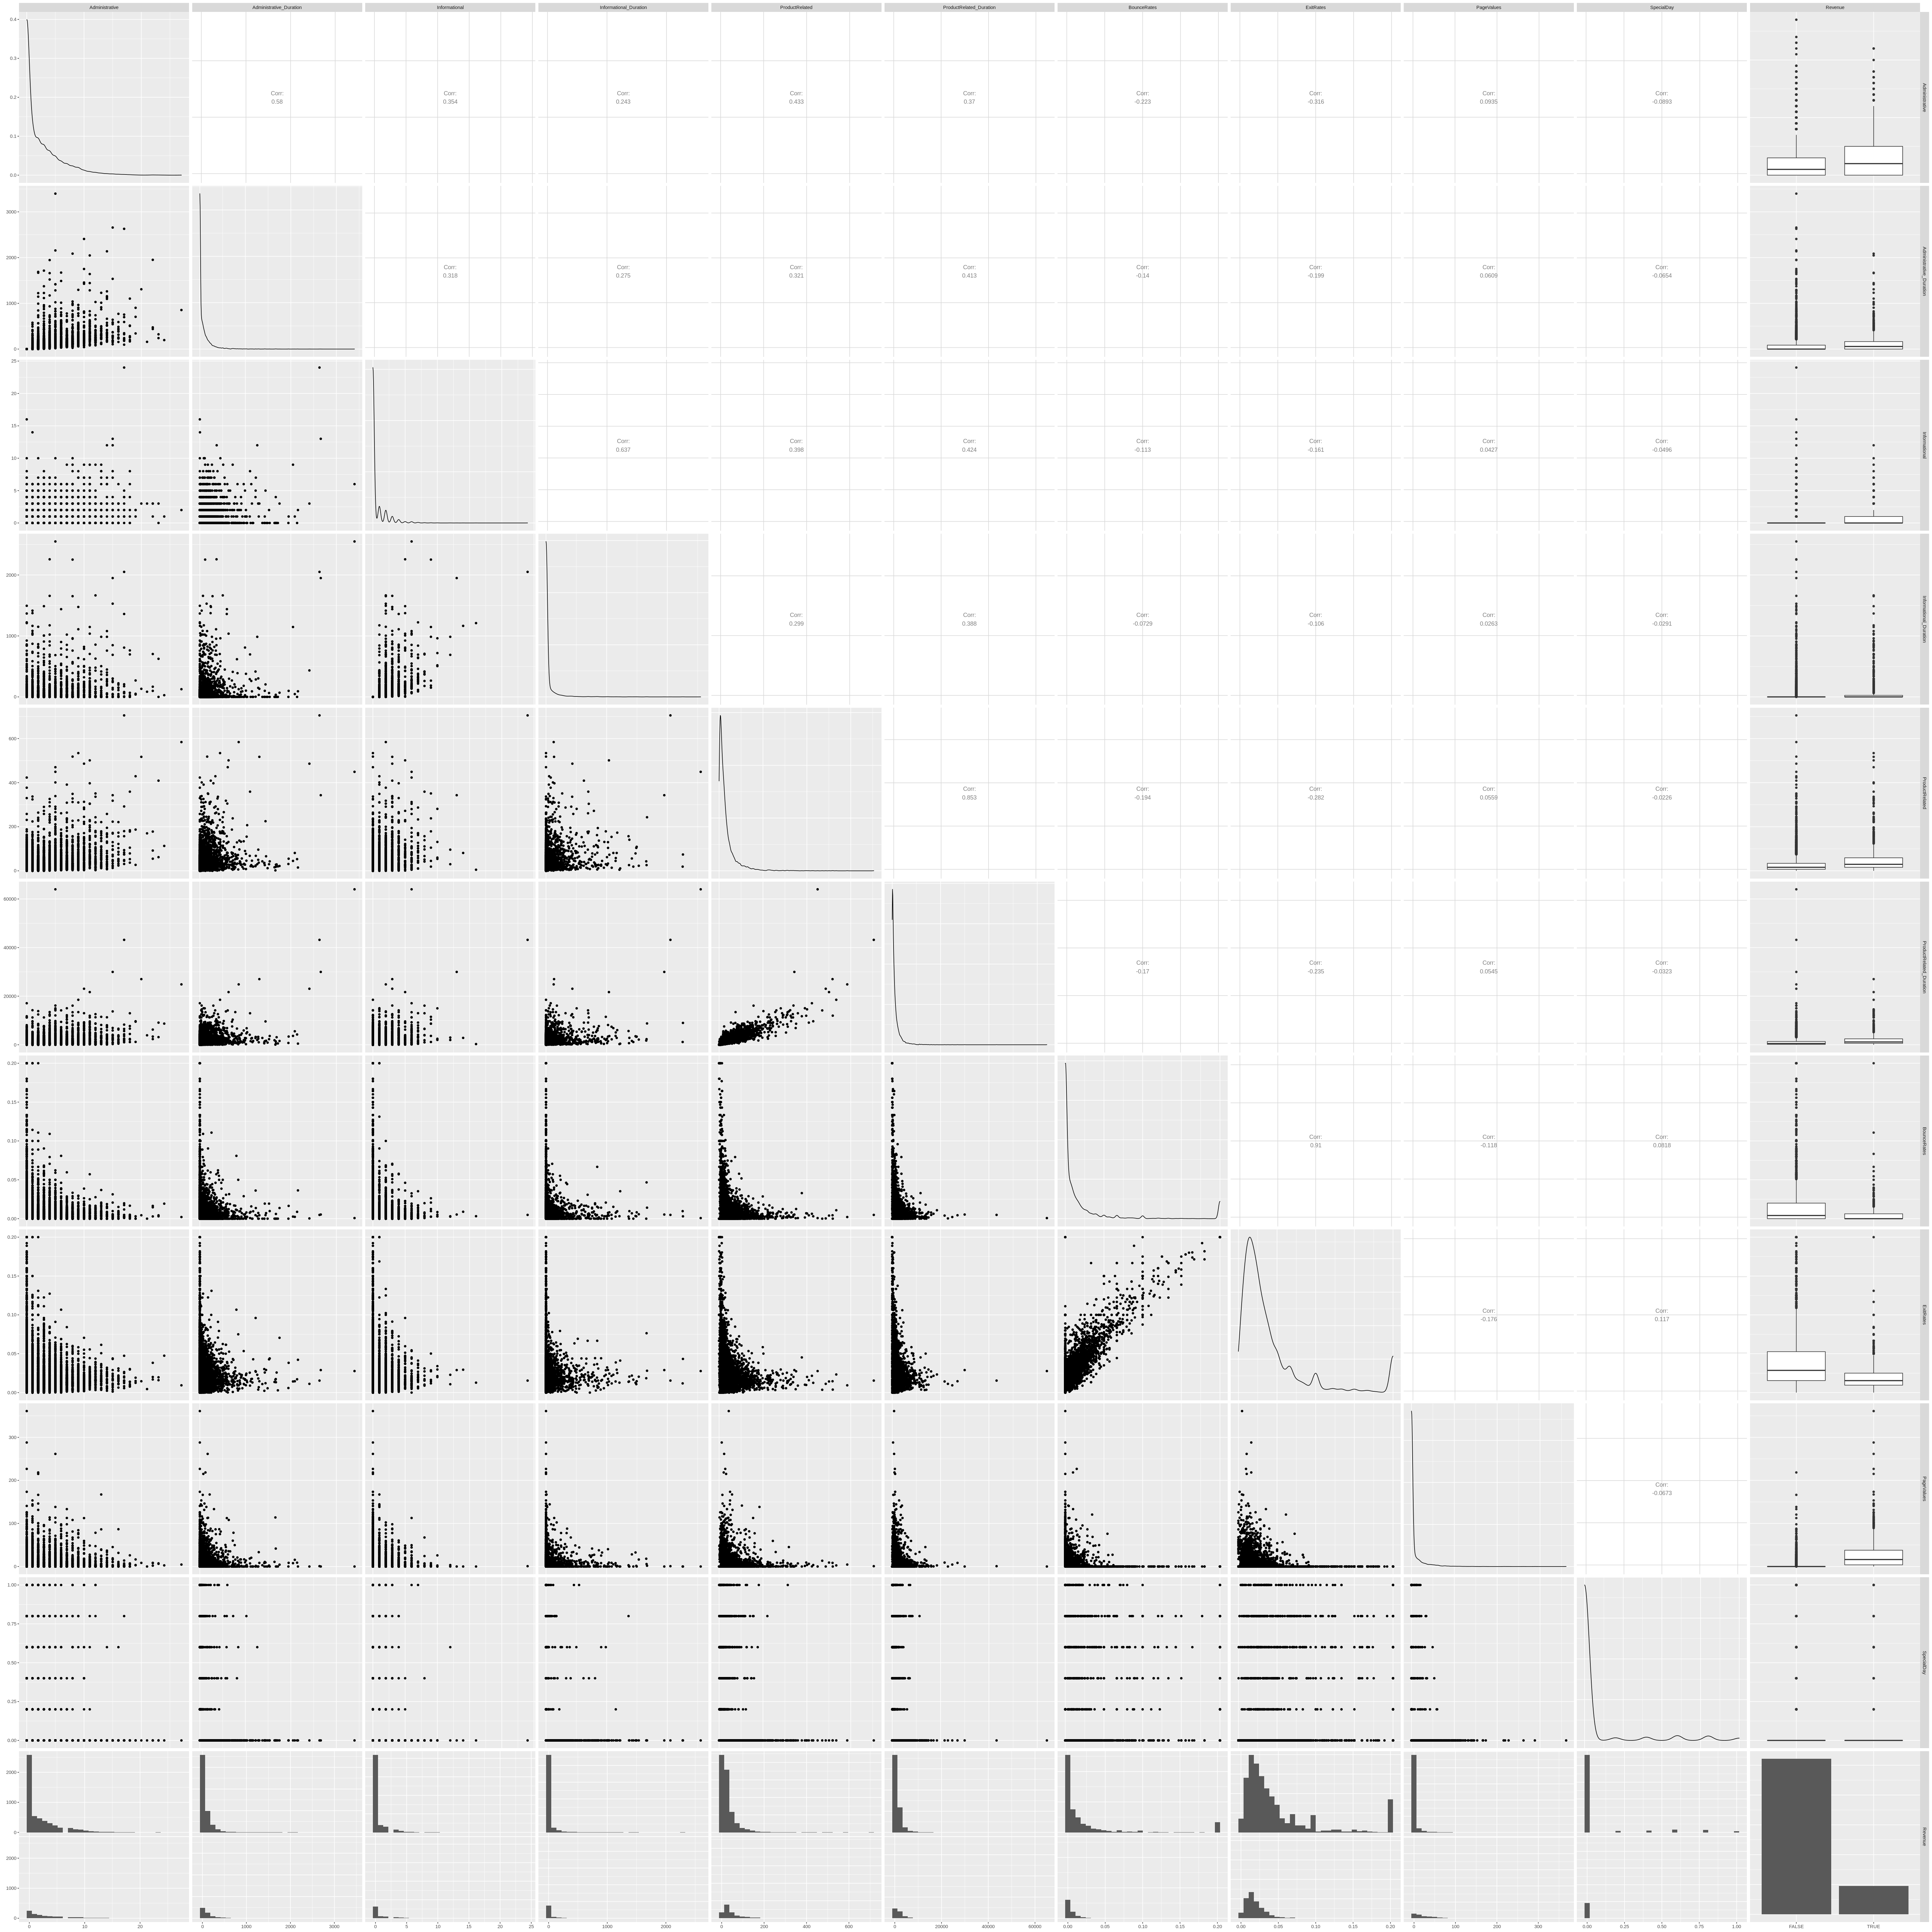

In [8]:
options(repr.plot.height = 50, repr.plot.width = 50)
shopper_eda <- ggpairs(shoppers_train)
shopper_eda

We have used the `ggpairs()` function from the GGally package to explore the relationships between the different variables in the dataset.

## Data Analysis:

### Pre-processing:

### Balancing Data

From the summary of the dataset, we observe that our data is quite imbalanced. Hence, we would be upsampling our “true” values of the Revenue class to avoid our model being biased against predicting it.

In [9]:
ups_recipe <- recipe(Revenue ~ ., data = shoppers_train) %>% 
  step_upsample(Revenue, over_ratio = 1, skip = FALSE) %>% 
  prep()
ups_recipe

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         10

Training data contained 6165 data points and no missing data.

Operations:

Up-sampling based on Revenue [trained]

In [10]:
shoppers_train <- bake(ups_recipe, shoppers_train)

shoppers_train %>% 
  group_by(Revenue) %>% 
  summarize(n = n())

`summarise()` ungrouping output (override with `.groups` argument)



Revenue,n
<fct>,<int>
FALSE,5211
TRUE,5211


### Selecting predictors using forward selection

In [11]:
shoppers_subset <- shoppers_train
names <- colnames(shoppers_subset %>% select(-Revenue))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
cancer_vfold <- vfold_cv(shoppers_subset, v = 5, strata = Revenue)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Revenue", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        shoppers_recipe <- recipe(as.formula(model_string), data = shoppers_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors()) 

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(shoppers_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = cancer_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Revenue ~ ProductRelated_Duration,0.8955106
2,Revenue ~ ProductRelated_Duration+PageValues,0.9398387
3,Revenue ~ ProductRelated_Duration+PageValues+Administrative_Duration,0.9449254
⋮,⋮,⋮
8,Revenue ~ ProductRelated_Duration+PageValues+Administrative_Duration+ExitRates+SpecialDay+BounceRates+Informational+Informational_Duration,0.9499140
9,Revenue ~ ProductRelated_Duration+PageValues+Administrative_Duration+ExitRates+SpecialDay+BounceRates+Informational+Informational_Duration+Administrative,0.9456918
10,Revenue ~ ProductRelated_Duration+PageValues+Administrative_Duration+ExitRates+SpecialDay+BounceRates+Informational+Informational_Duration+Administrative+ProductRelated,0.9425261


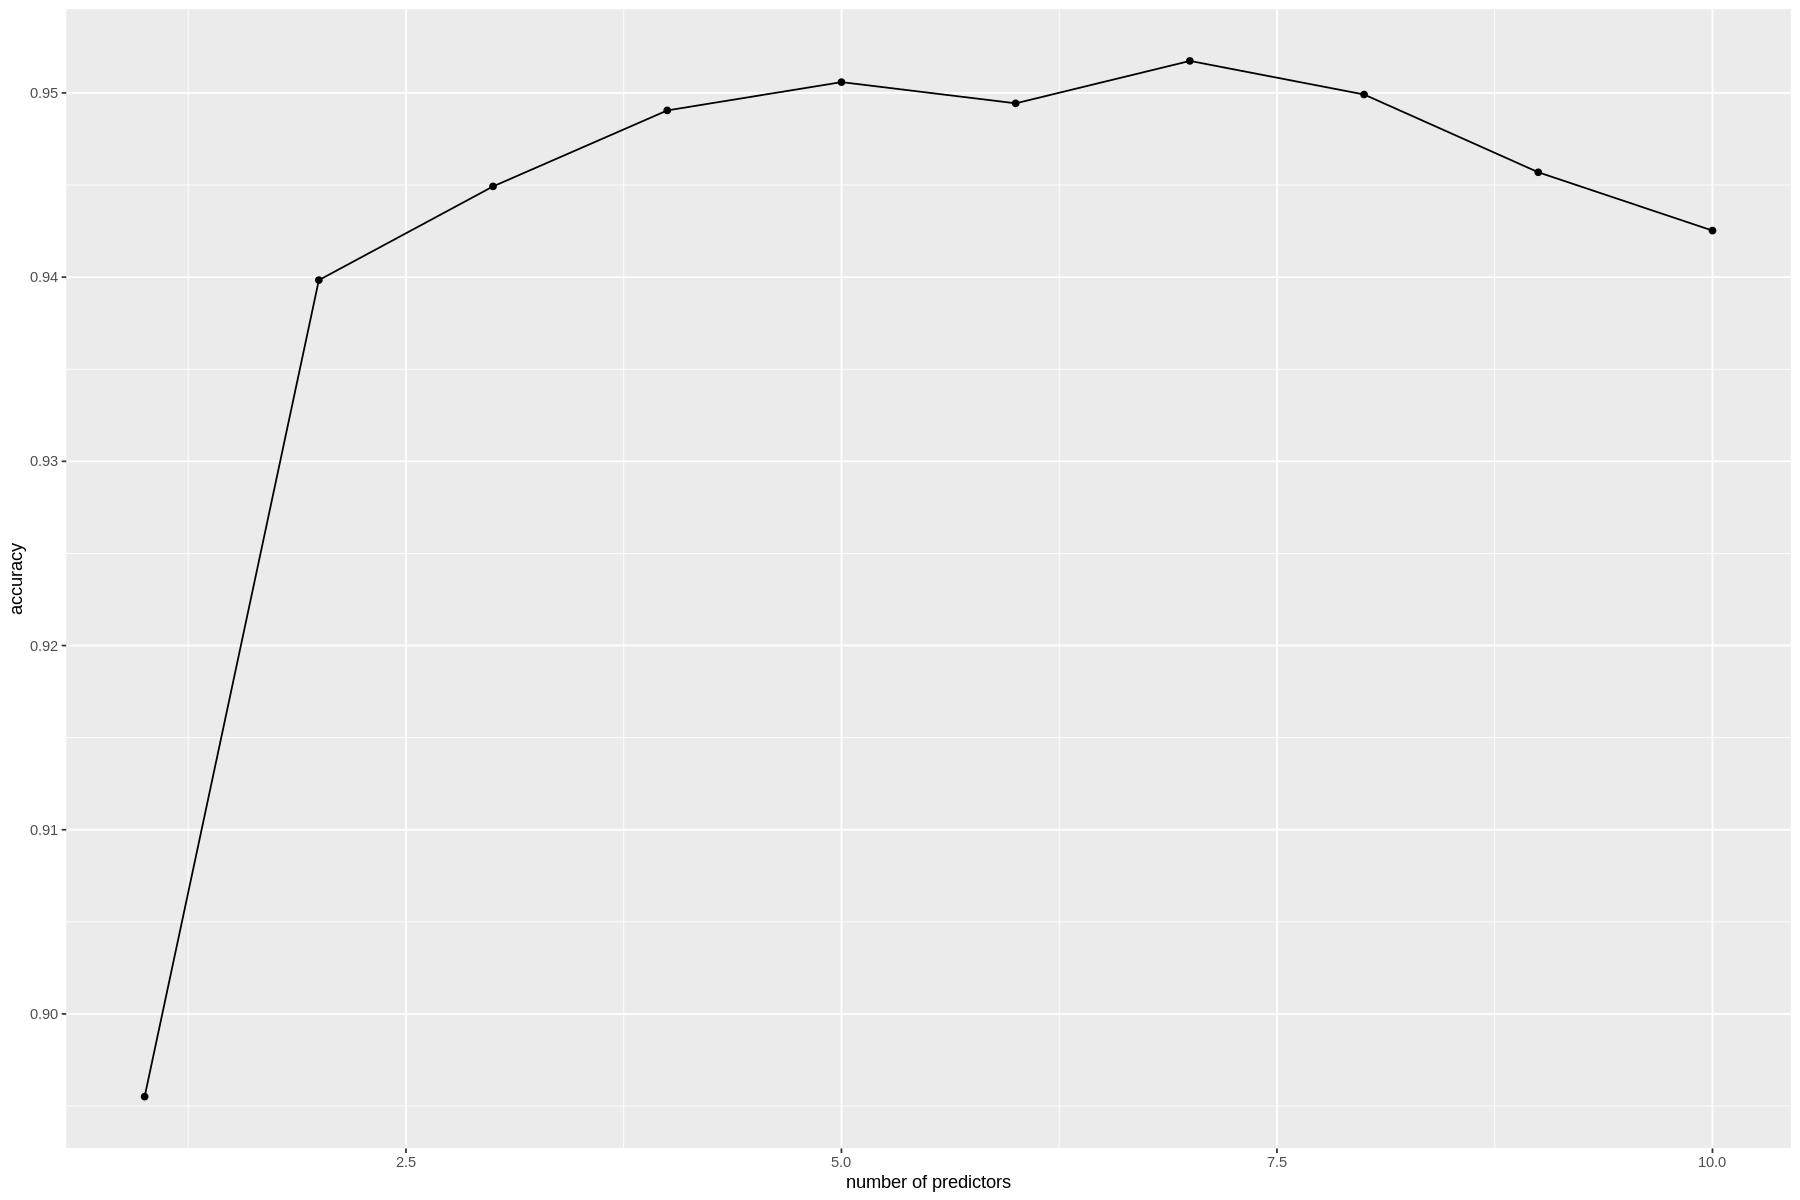

In [14]:
options(repr.plot.height = 10, repr.plot.width = 15)
accuracies_plot <- accuracies %>%
                   ggplot(aes(x = size, y = accuracy)) +
                   geom_point() +
                   geom_line() +
                   labs(x = "number of predictors", y = "accuracy")
accuracies_plot

From the graph, we see that the model hits an elbow point and the accuracy starts to level off and fluctuates after 3 predictors. Hence, that is the set of predictors we would be using for our analysis. 

Therefore, our prediction model would be: 

#### Revenue ~ ProductRelated_Duration + PageValues + Administrative_Duration, where,  

**ProductRelated_Duration**: Total amount of time (in seconds) spent by the visitor on product related pages,

**PageValues**: Average page value of the pages visited by the visitor as measured by "Google Analytics" metrics for each page in the e-commerce site,

**Administrative_Duration**: Total amount of time (in seconds) spent by the visitor on account management related pages,

### Parameter value selection (K value) for classification

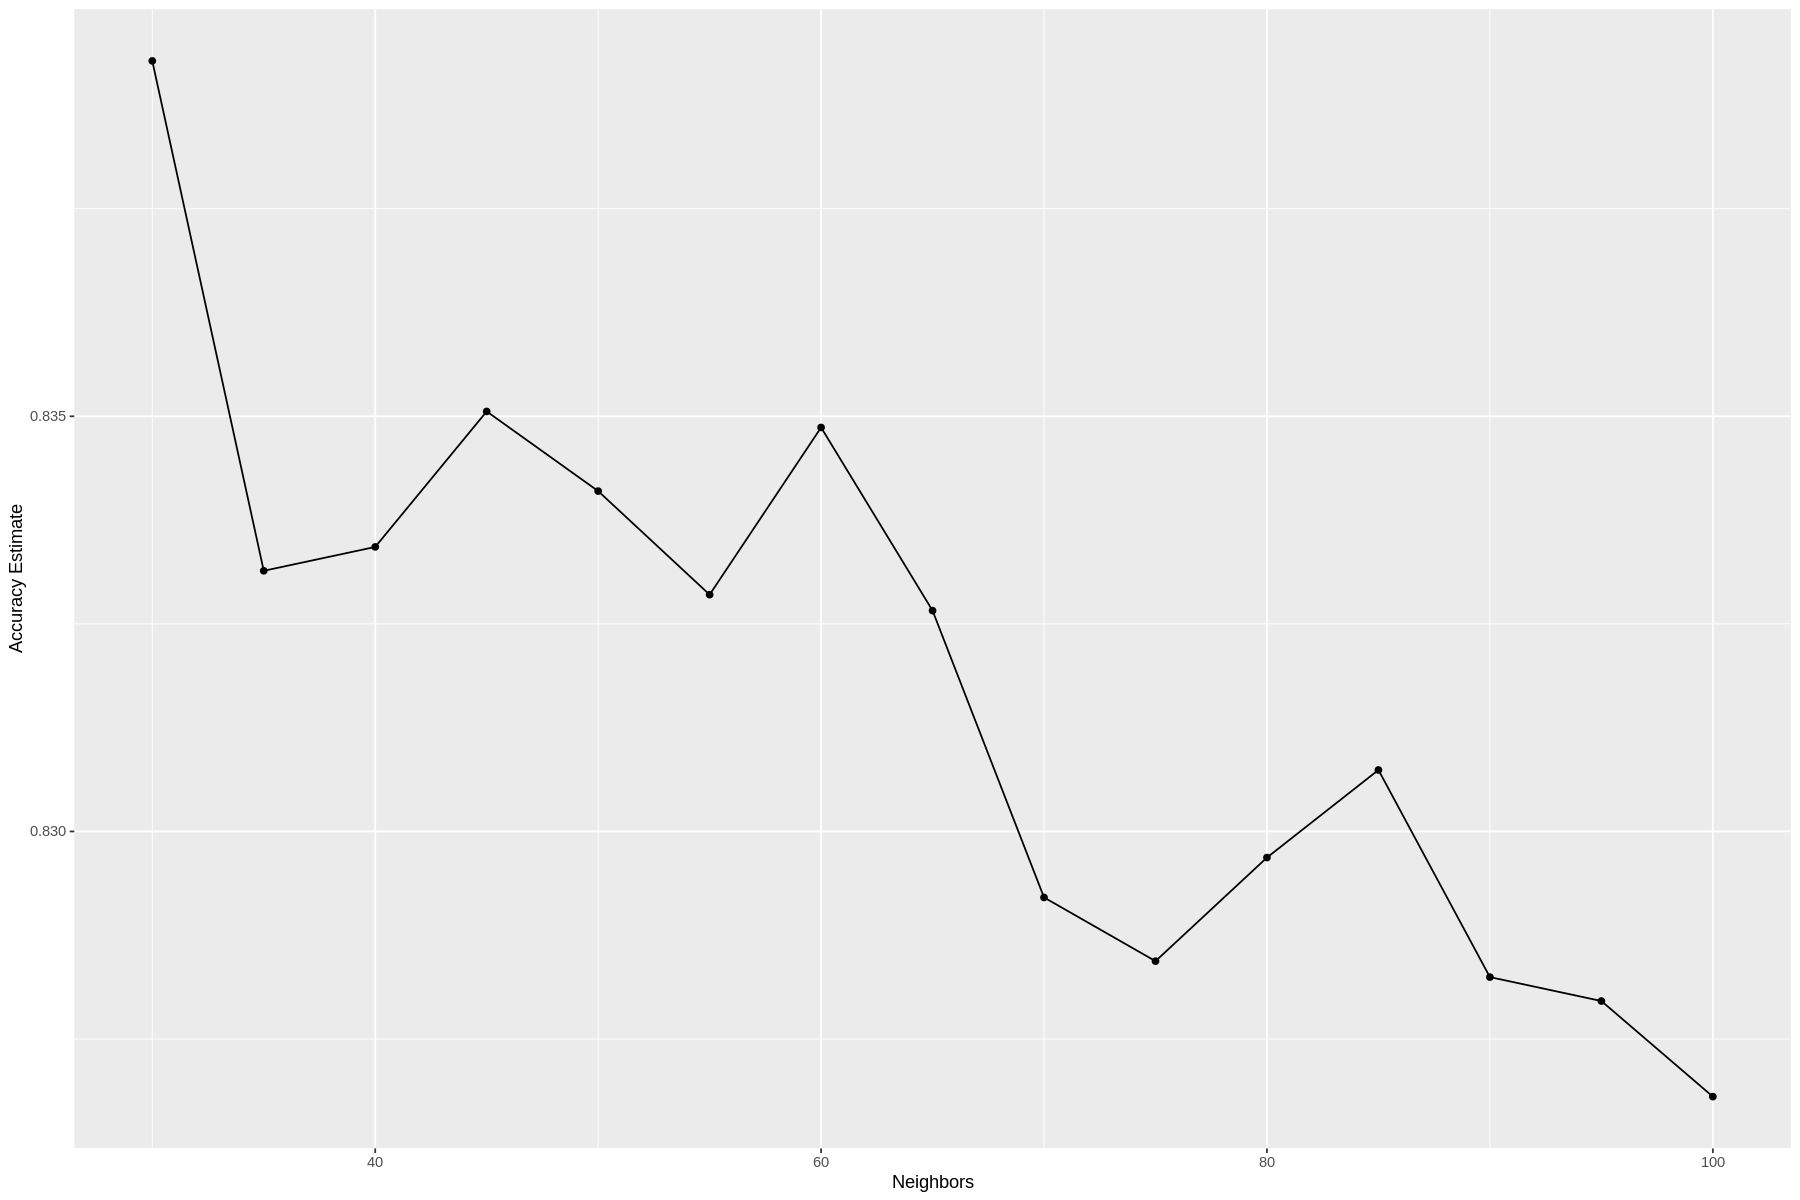

In [48]:
set.seed(1234) 

options(repr.plot.height = 10, repr.plot.width = 15)

training_recipe <- recipe(Revenue ~ ProductRelated_Duration + PageValues + Administrative_Duration
                          , data = shoppers_train) %>% 
                   step_scale(all_predictors()) %>% 
                   step_center(all_predictors())

training_vfold <- vfold_cv(shoppers_train, v = 10, strata = Revenue)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

# try it in sequence from 1 to 385 in the first iteration
# k_lots <- tibble(neighbors = seq(from = 1, to = 385, by = 10))

# zoom in to narrow down the range of values based on the observations in the first iteration
k_lots <- tibble(neighbors = seq(from = 30, to = 100, by = 5))

knn_results <- workflow() %>%
       add_recipe(training_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = training_vfold, grid = k_lots) %>%
       collect_metrics ()

knn_accuracy <- knn_results %>% 
        filter(.metric == "accuracy")

cross_val_plot <- ggplot(knn_accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")

cross_val_plot

From the graph we see that the model significantly overfits until k = 30 (, hence the large drop in accuracy). Thereforefore, we would be using k = 50 as our parameter value since it is the local maximum (ignoring overfitting) with minimal fluctuations.

In [57]:
kval <- 50
kval

[1] 50

### Training the model

In [58]:
shoppers_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kval) %>%
                 set_engine("kknn") %>%
                 set_mode("classification")

shoppers_fit <- workflow() %>%
                add_recipe(training_recipe) %>%
                add_model(shoppers_spec) %>%
                fit(data = shoppers_train)

shoppers_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~kval,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1634043
Best kernel: rectangular
Best k: 50

### Predicting the testing data

In [59]:
shoppers_test_predictions <- predict(shoppers_fit, shoppers_test) %>%
bind_cols(shoppers_test)
shoppers_test_predictions

.pred_class,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
FALSE,0,0,0,0,2,64.0000,0.00000000,0.1000000,0,0.0,FALSE
FALSE,0,0,0,0,19,154.2167,0.01578947,0.0245614,0,0.0,FALSE
FALSE,0,0,0,0,1,0.0000,0.20000000,0.2000000,0,0.4,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,0,0,0,0,5,465.75,0.00000000,0.02133333,0,0,FALSE
FALSE,0,0,0,0,6,184.25,0.08333333,0.08666667,0,0,FALSE
FALSE,0,0,0,0,3,21.25,0.00000000,0.06666667,0,0,FALSE


### Evaluating the accuracy of our classifier

In [60]:
  shoppers_test_predictions %>% 
  metrics(truth = Revenue, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8510949
kap,binary,0.5318154


In [61]:
confusion <- shoppers_test_predictions %>% 
             conf_mat(truth = Revenue, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE  4500  207
     TRUE    711  747

## Methodology:

## Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## <a id='references'></a>References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

- Wickham, Hadley, and others. 2014. “Tidy Data.” Journal of Statistical Software 59 (10): 1–23.
- Cue consistency and page value perception: Implications for web-based catalog design.
- Analysis of Queues with Impatient Clients: An Application to Online Shopping
- Kabir, Md Rayhan & Ashraf, Faisal & Ajwad, Rasif. (2019). Analysis of Different Predicting Model for Online Shoppers’ Purchase Intention from Empirical Data. 

In [ ]:
for (i in 1:n_total) {
    ...
    for (j in 1:length(names)) {
       ...
    }
    ...
}